# MetaboBlend

## Example data

For this example, we load D-Glucose (HMDB0000122) before generating a database of its
substructures; MetaboBlend leverages substructures of known endogenous compounds to
generate candidate structures for a given molecular composition and exact mass. We
can additionally annotate MSn spectra in order to rank candidate lists.

In [26]:
# standard imports
import os
import sys
import zipfile

# rdkit - manipulation of molecules
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

# metaboverse imports
from metaboblend.databases import create_isomorphism_database
from metaboblend.databases import create_substructure_database
from metaboblend.build_structures import generate_structures
from metaboblend.build_structures import annotate_msn

# extract test data
zip_ref = zipfile.ZipFile(os.path.join("..", "tests", "data", "test_mols.zip"), 'r')
zip_ref.extractall("notebook_data")
zip_ref.close()

## Database generation

MetaboBlend requires a connectivity and substructure database in order to
propose candidate structures. Combinations of substructures are considered
by MetaboBlend to propose candidate structures for a metabolite of interest.


In [6]:
if sys.platform == "win32" or sys.platform == "win64":  # TODO: add RI as dependency
    path_ri = os.path.join("..", "tools", "RI_win", "RI3.6-release", "ri36")

elif sys.platform == "darwin":
    path_ri = os.path.join("..", "tools", "RI_mac", "RI3.6-release", "ri36")

elif sys.platform == "linux2":
    if "bb" in "socket.gethostname":
        path_ri = os.path.join("..", "tools", "RI_unix", "RI3.6-release", "ri36")
    else:
        path_ri = os.path.join("..", "tools", "RI_bb", "RI3.6-release", "ri36")

elif sys.platform == "linux":
    path_ri = os.path.join("..", "tools", "RI_unix", "RI3.6-release", "ri36")

else:
    path_ri = os.path.join("..", "ri36")

create_isomorphism_database("../databases/connectivity_graphs.sqlite",
                           max_atoms_available=2,
                           max_n_substructures=3,
                           path_ri=path_ri)

create_substructure_database([os.path.join("notebook_data", "test_mols", "hmdb", "HMDB0000122.xml")],
                             "../databases/substructures.sqlite", n_min=2, n_max=12)

## Standard structure generation

Candidate structures can be generated for a given molecular formula and
exact mass from the generated databases. Since this method doesn't use
MS/MS information, many unique structures can be generated and candidates
are not assigned a relative score.

The function yields a set of smiles for each compound in ms_data
(in this case, only HMDB0000122). After extracting smiles, RDKit can be
used to visualise generated structures.

['OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O', 'OC[C@@H]1C(O)O[C@@H](O)[C@H](O)[C@H]1O', 'OC1[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)[C@H]1O']


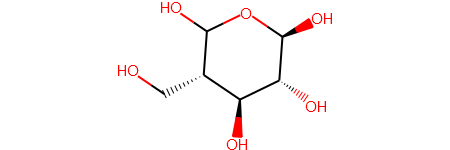

In [15]:
ms_data = {"HMDB0000122": {"mc": [6, 12, 0, 6, 0, 0], "exact_mass": 180.063388116}}

struct_generator = generate_structures(ms_data,
                                       heavy_atoms=range(2, 13), max_valence=6,
                                       max_atoms_available=2, max_n_substructures=3,
                                       path_connectivity_db="../databases/k_graphs.sqlite",
                                       path_substructure_db="../databases/substructures.sqlite")

# convert generated sets of smiles to rdkit.Chem.Mol objects
generated_mols = [Chem.MolFromSmiles(smiles) for i, smiles in enumerate(list(struct_generator)[0])]
generated_mols[0]

## MS/MS guided structure generation

MSn spectra provide a means of scoring candidates and limiting
the generation of unrealistic structures. A list of neutral
masses can be provided with the molecular composition and exact
mass of a metabolite of interest to inform the annotation process.
These masses may have been calculated from the fragment ions of
an MS2 spectrum; in this example, the masses of known substructures
have been chosen.


Total structures generated: 23
Number of structures generated by all peaks: 1
3


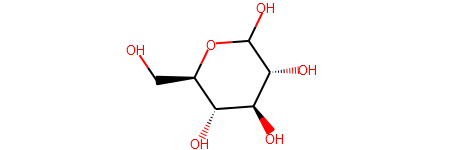

In [44]:
ms_data = {"HMDB0000122": {"mc": [6, 12, 0, 6, 0, 0], "exact_mass": 180.063388116,
                           "prescribed_masses": [46.0055, 60.0211, 73.029]}}  #

annotation_generator = annotate_msn(ms_data, heavy_atoms=range(2, 13), max_valence=6,
                                    max_atoms_available=2, max_n_substructures=3, ppm=5,
                                    path_connectivity_db="../databases/k_graphs.sqlite",
                                    path_substructure_db="../databases/substructures.sqlite")

annotated_structures = list(annotation_generator)[0]
print("Total structures generated: " + str(len(annotated_structures)))
print("Number of structures generated by all peaks: " + str(list(annotated_structures.values()).count(3)))

print(annotated_structures["OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O"])
Chem.MolFromSmiles("OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O")